##  Рекомендательная система подбора недвижимости

##### 1.1 Парсинг сайта ЕГСН

In [2]:
#Подключаю все необходимые библиотеки

from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import numpy as np
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

In [ ]:
#Парсер сайта ЕГСН, для получения актуальной информации о стоимости квартир в Москве
data = []
for i in range(1,2306,1):
    url = 'https://www.egsnk.ru/kvartiry/kupit/p'
    url = url + str(i)
    page = requests.get(url)
    if page.status_code != 200:
        print(page.status_code)
        exit()
    soup = BeautifulSoup(page.text, features="html.parser")
    flats = soup.find_all('div', class_='res_row clearfix')  
    for flat in flats:
        block_01 = flat.find('div', class_='res_right')
        block_02_01 = flat.find_all('div', class_='mt8')
        block_02_02 = block_02_01[0]
        block_03 = flat.find('div', class_='res_text fs15')
        block_03_02 = block_03.find_all('div')
        block_03_03 = block_03_02[0]
            
        text_01 = block_01.text.strip().replace('\n', '\t')
        cost = float(''.join([x for x in text_01 if x.isdigit() or x == '.']))
        description = block_03_03.text.strip().replace('\n', '\t')
        info = block_03.text.strip().replace('\n', '\t')
        address = block_02_02.text.strip().replace('\n', '\t')

        data.append({
                'cost': cost,
                'address': address,
                'description': description,
                'all_info': info,
            })
df = pd.DataFrame(data).to_csv('data_all.csv')

##### 1.2 Обработка полученных данных

In [ ]:
flat =pd.read_csv('E:\project university\Выпускная работа\DataSet\Недвижка\my_DS\data_all.csv')
flat[['rooms', 'square','floor1']] = flat['description']. str.split('|', 0 , expand= True )# разделяю значения по столбцам
flat['all_info'] =flat.apply(lambda x: x['all_info'].replace(x['address'],''), axis=1) # удаляю из all_info ифу по address
flat['all_info'] =flat.apply(lambda x: x['all_info'].replace(x['description'],''), axis=1) # удаляю из all_info ифу по description
flat = flat.drop(columns='description') #удаляю колонку старого дескрипшина
flat[['des_property']] = flat['all_info'].str.extract('(?:(?<=пешком)|(?<=транспортом))(.*)', 0, expand= True) #добавляю новый дескрипшн
flat.des_property.fillna(flat.all_info, inplace=True) # копирую описание из all_info в ячейки NAN
flat['all_info'] =flat.apply(lambda x: x['all_info'].replace(x['des_property'],''), axis=1) # удаляю из all_info ифу по property и получаю метро
flat.rename(columns={'all_info': 'metro','des_property': 'description'},inplace = True )# переименовываю столбцы
flat = flat.drop(columns='Unnamed: 0') 
flat['cost_for_meter(₽)'] =((flat['cost'])/(flat['square'].str.extract(r'(.*(?=\м²))', expand=False).astype("float"))).astype("float") # получаю еще один столбец с ценой квадратного метра
flat['cost_for_meter(₽)'] = round(flat['cost_for_meter(₽)'],1) #округляю до десятых
flat['cost']=flat['cost'].astype("int") 
flat.rename(columns={'cost': 'cost(₽)'},inplace = True )# переименовываю столбцы
                                                  # Перевожу пешком и на транспорте в метры от метро и очищаю от букв
flat[['metro_name', 'min']] = flat['metro'].str.split(',' , 1 , expand = True)# Отделяю минуты и название метро
flat['metro_name'] = flat['metro_name'].str.lower()# Перевод названий станций в нижний регистр
flat['min_int'] =flat['min'].str.extract(r'(\d+(?= \мин.))').fillna(0) #Выделяю только цифры
flat['min_int'] =flat['min_int'].astype("int")#перевожу в INT
flat['alpha'] = flat['min'].str.contains('пешком') # нахожу слова -пешком истина -есть ложь нет
flat['alpha']=flat['alpha'].replace({False:333,	True:84}).fillna(0).astype("int") # меняю ложь на 333 м/мин (20км/ч) и истину на 84 м/мин(5км/ч), и перевожу в INT
flat['distance(м)']= flat['alpha']*flat['min_int'] # перемножаю минуты на скорость получаю метры до метро
flat['distance(м)']=flat['distance(м)'].astype("float") # перевожу расстояние до метро в тип флоат
flat[['floor2']] = flat['floor1'].str.extract('(?:(?<=этаж))(.*)', 0, expand= True)# удаляю слово этаж
flat[['floor','floors']] = flat['floor2'].str.split('/', 0 , expand= True )# разделяю значения этажей по столбцам
flat['floor']=flat['floor'].astype("int") # перевожу этаж в тип INT
flat['floors']=flat['floors'].astype("int") # перевожу этажи в тип INT
flat[['square(м²)','DEL']] = flat['square'].str.split('м', 0 , expand= True ) # удаляю ненужные м²
flat['square(м²)']=flat['square(м²)'].astype("float")# перевожу площадь в тип флоат
flat = flat.drop(['alpha','min_int','min','metro','floor1','floor2','square','DEL'],axis=1) # удаляю промежуточные столбцы для вычислений
flat = flat[['rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','floor','floors','description']]#порядок столбцов
#Удаляю строки с неверными данными
flat=flat.drop(axis=1, index=31397)
flat=flat.drop(axis=1, index=31401)
flat=flat.drop(axis=1, index=646)
flat.to_csv('E:\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat22.csv', index=False)
flat.head(5)

In [5]:
flat.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,1 – комнатная,5000000,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1 комната,4500000,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,1 – комнатная,10900000,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,1 комната,3650000,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,доля (1/2),1200000,72.3,16597.5,"Центральная ул., 6",NaN,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 1.3 Обработка данных скачанных из Kaggle

In [ ]:
#Обработка данных из Kaggle
flat_full =pd.read_csv('moscow_full_2.0.csv')
flat_full[['rooms', 'square','floor1']] = flat_full['title']. str.split(', ', 0 , expand= True )# разделяю значения по столбцам
flat_full.rename(columns = {'adress' : 'address'}, inplace = True) # меняю наименование на корректное
flat_full = flat_full.drop(columns='title') #удаляю колонку старого title
flat_full[['floor2','floor3']] = flat_full['floor1'].str.split('э', 0 , expand= True ) # разделяю floor1 значения по столбцам
flat_full[['floor', 'floors']] = flat_full['floor2']. str.split('/', 0 , expand= True ).fillna(0)# разделяю floor2 значения по столбцам
flat_full['floor']=flat_full['floor'].astype("int") # перевожу этаж в тип INT
flat_full['floors']=flat_full['floors'].astype("int") # перевожу этажи в тип INT
flat_full[['square(м²)','DEL']] = flat_full['square'].str.split('м', 0 , expand= True ) # удаляю ненужные м²
flat_full['square(м²)']=flat_full['square(м²)'].astype("float")# перевожу площадь в тип флоат
                               # Очищаю cost_for_meter(₽)
flat_full[['cost_for_meter(₽)', 'DEL1']] = flat_full['cost_for_meter']. str.split(' ₽ ', 0 , expand= True )# разделяю значения по столбцам
flat_full['cost_for_meter(₽)']=flat_full['cost_for_meter(₽)'].fillna(0)# меняю нан на 0
mask = flat_full['cost_for_meter(₽)'].str.fullmatch(r'[\d ]*')# ввожу переменную с регулярным выражением
flat_full.loc[mask, 'cost_for_meter(₽)'] = flat_full.loc[mask, 'cost_for_meter(₽)'].str.replace(' ', '')# меняю replace ом пробел
flat_full['cost_for_meter(₽)']=flat_full['cost_for_meter(₽)'].astype("int")# перевожу в флоат
flat_full['cost_for_meter(₽)'] = (flat_full['cost_for_meter(₽)'] + ((flat_full['cost_for_meter(₽)'])*(34/100)))
                               # Очищаю cost
flat_full[['cost(₽)', 'DEL2']] = flat_full['cost']. str.split('₽', 0 , expand= True )# разделяю значения по столбцам
flat_full['cost(₽)']=flat_full['cost(₽)'].fillna(0)# меняю нан на 0
mask = flat_full['cost(₽)'].str.fullmatch(r'[\d ]*')# ввожу переменную с регулярным выражением
flat_full.loc[mask, 'cost(₽)'] = flat_full.loc[mask, 'cost(₽)'].str.replace(' ', '')# меняю replace ом пробел
flat_full['cost(₽)']=flat_full['cost(₽)'].astype("float")# перевожу в float
flat_full['cost(₽)'] = (flat_full['cost(₽)'] + ((flat_full['cost(₽)'])*0.34)) # увеличиваю на 34%
                                # Получаю расстояние в метрах
flat_full['min_int']= flat_full['metro'].str.extract(r'([-+]?(?:\d+(?:\.\d*)?|\.\d+))(?= м| км)').fillna(0) #Выделяю только цифры
flat_full['min_int']=flat_full['min_int'].astype("float")# перевожу в INT
flat_full['alpha1'] = flat_full['metro'].str.contains(' км') # нахожу слова -км истина -есть ложь нет
flat_full['alpha1']=flat_full['alpha1'].replace({False:1,	True:1000}).fillna(0).astype("int") # меняю ложь на 1  и истину на 1000 (в 1 км =1000м), и перевожу в INT
flat_full['distance(м)']= flat_full['alpha1']*flat_full['min_int']  # получаю расстояние от метров метрах
                                # выделяю название метро
flat_full['metro_name']= flat_full['metro'].str.extract(r'(.*(?= \d))') # выделяю название метро
flat_full ['metro_name'] = flat_full ['metro_name'].str.lower()# перевод названий станций в нижний регистр
                                # удаляю промежуточные колонки
flat_full = flat_full.drop(['floor3','floor2','floor1','DEL','square', 'cost_for_meter', 'DEL1','cost','DEL2','min_int','alpha1','metro'],axis=1)  #удаляю промежуточные колонки
flat_full= flat_full[['rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','floor','floors','description']]#порядок столбцов
flat_full.to_csv('moscow_flat20.csv',index=False)
flat_full.head(5)



![title](https://github.com/Gabuchev/Apartments-in-Moscow---The-simplest-recommendation-system/blob/main/123.PNG)

In [ ]:
#![title](/C:\Users\Daniel\OneDrive\Документы\GitHub\Recommendation-system-V.1\123.PNG)

In [3]:
flat_full.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,Квартира своб. планировки,50920000.00,130.00,391692.72,"Москва, 3-я улица Ямского Поля, 9к3",белорусская,407.0,5,5,Представляю Вашему вниманию 2-х уровневый пент...
1,2-комн. квартира,62980000.00,93.00,677203.84,"Москва, Ленинградский проспект, 36с31",динамо,612.0,6,10,В премиальном ЖК Hyatt Regency предлагаем Ваше...
2,1-комн. квартира,11792000.00,36.00,327554.96,"Москва, Печорская улица, 5",бабушкинская,792.0,5,16,"Свободная продажа, никто не прописан. В кварти..."
3,1-комн. квартира,11806521.58,47.59,248088.94,пр-т Нахимовский,профсоюзная,1400.0,0,0,Многофункциональный комплекс «Нахимов» предста...
4,1-комн. квартира,15678000.00,36.00,435500.00,"Москва, Новорогожская улица, 11к2",римская,446.0,6,12,Собственник. Риелторов и прочих помогателей ПР...


##### 1.4 Поиск и удаление дубликатов

In [236]:
flat =pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat22.csv')
flat_full=pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat20.csv')

In [237]:
duplicate_flat22 = flat[flat.duplicated ()]
duplicate_flat20 = flat_full[flat_full.duplicated ()]

In [141]:
duplicate_flat22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11485 entries, 1425 to 44845
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rooms              11485 non-null  object 
 1   cost(₽)            11485 non-null  int64  
 2   square(м²)         11485 non-null  float64
 3   cost_for_meter(₽)  11485 non-null  float64
 4   address            11485 non-null  object 
 5   metro_name         6004 non-null   object 
 6   distance(м)        11485 non-null  float64
 7   floor              11485 non-null  int64  
 8   floors             11485 non-null  int64  
 9   description        11438 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 987.0+ KB


In [240]:
duplicate_flat20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 1299 to 55662
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rooms              533 non-null    object 
 1   cost(₽)            533 non-null    float64
 2   square(м²)         533 non-null    float64
 3   cost_for_meter(₽)  533 non-null    float64
 4   address            530 non-null    object 
 5   metro_name         457 non-null    object 
 6   distance(м)        533 non-null    float64
 7   floor              533 non-null    int64  
 8   floors             533 non-null    int64  
 9   description        533 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 45.8+ KB


In [241]:
flat = flat.drop_duplicates()
flat_full = flat_full.drop_duplicates()

##### 1.5 Объединение датафреймов

In [242]:
# Слияние датасетов
frames = [flat, flat_full]
result = pd.concat(frames)
result.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Realty.csv',index=False) 

In [243]:
result.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",NaN,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 1.6 Проверка полученных данных (ядерная оценка плотности)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_11452\1412638651.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flat_20['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="dodgerBlue", label="Данные за 2020г", alpha=.3)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_11452\1412638651.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flat_22['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="mediumseagreen", label="Данные за 2022г", alpha=.3)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_11452\1412638651.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flat_total['cost_for_meter(₽)']

<function matplotlib.pyplot.show(close=None, block=None)>

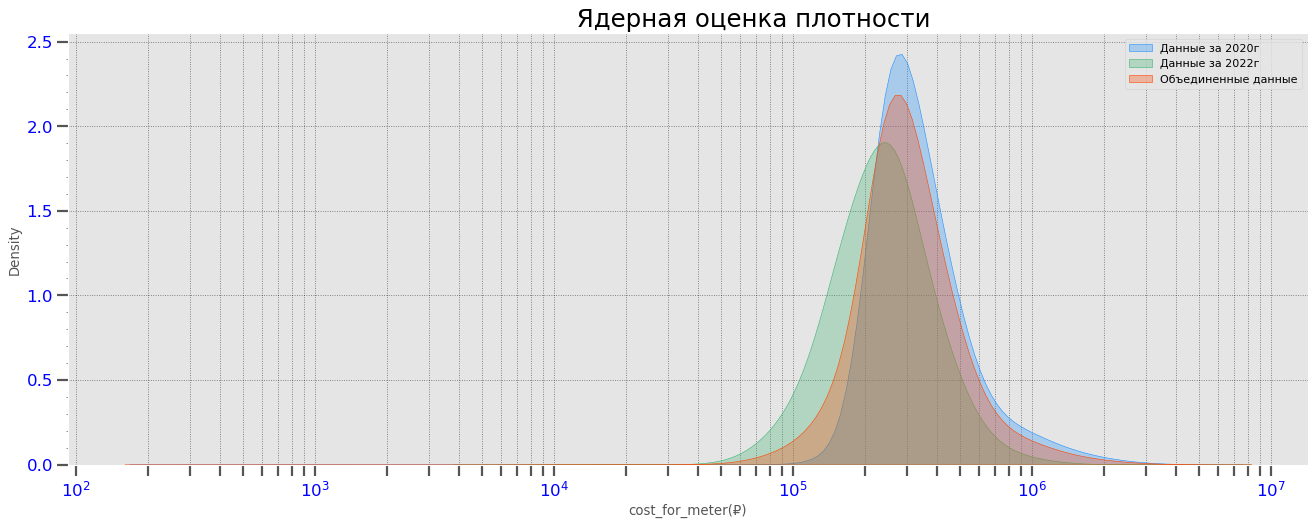

In [29]:
#Распределение случайной величины

#создание области графика
plt.figure(figsize=(20,7), dpi=80)
#считывание файлов csv
flat_total= pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Realty.csv')
flat_22 = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat22.csv')
flat_20 = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\Недвижка\my_DS\moscow_flat20.csv')
#построение распределений
sns.kdeplot(flat_20['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="dodgerBlue", label="Данные за 2020г", alpha=.3)
sns.kdeplot(flat_22['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="mediumseagreen", label="Данные за 2022г", alpha=.3)
sns.kdeplot(flat_total['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.4,color="orangered", label="Объединенные данные", alpha=.3)
#управление настройками сетки
plt.grid(axis='x',which='both', linestyle=':',color="black",alpha=.5)
plt.grid(axis='y',which='major', linestyle=':',color="black",alpha=.5)
#надписи координатных осей
plt.minorticks_on()
#plt.xlabel('Стоимость за м²(в логарифмическом масштабе)', fontsize=16)
#plt.ylabel('Плотность', fontsize=16)
plt.tick_params(axis='x',which='both', length=10, width=2)
plt.tick_params(axis='y',which='major', length=10, width=2)
plt.xticks(color="b", size=15)
plt.yticks(color="b", size=15)
#титул, легенда 
plt.title('                 Ядерная оценка плотности', fontsize=22)
plt.legend()
#обновление графика вне интер-актива
#plt.figure(figsize=(6, 1))
plt.show



##### 1.7 Добавляю параметр-"расстояние от центра" до указанного метро (Спасская башня - условно центр)

In [ ]:
#Парсер удаленности метро от центра


#  список данных
data = []
# без цикла
page = requests.get('https://m.101hotels.com/recreation/russia/moskva/infrastructure/metro?ysclid=la3a4g68is638416669&page=23')
# проверка статуса страниц 
if page.status_code != 200:
    print(page.status_code)
    exit()
# индексация информации по выбранным тегам в блоки
soup = BeautifulSoup(page.text, features="html.parser")
metros = soup.find_all('li', class_='tiled_list_item')  
for metro in metros:
    block_01 = metro.find('div', class_='link__title')
    block_02 = metro.find('div', class_='center-distance')
# перевод блоков в строки и обработка строк
    name = block_01.text.strip().replace('\n', '\t')
    center_distance = block_02.text.strip().replace('\n', '\t')
# добавление в список данных
    data.append({
      'metro_name': name,
      'center_distance': center_distance,
            })
# выходной выйл
df = pd.DataFrame(data).to_csv('metro.csv',index=False)
# Обработка данных
metro =pd.read_csv('metro.csv')
#Выделяю только цифры
metro['center_distance']= metro['center_distance'].str.extract(r'([-+]?(?:\d+(?:\.\d*)?|\.\d+))(?= км)').fillna(0)
# перевожу расстояние до метро в метры, тип флоат
metro['center_distance/m']=(metro['center_distance'].astype("float"))*1000
# Перевод названий станций в нижний регистр
metro['metro_name'] = metro['metro_name'].str.lower()
#Удаляю столбец center_distance
metro = metro.drop(['center_distance'],axis=1) 
# выходной выйл
metro.to_csv('metro.csv',index=False)

In [6]:
metro.head(5)

,metro_name,center_distance/m
0,театральная,600.0
1,чеховская,1500.0
2,охотный ряд,500.0
3,тверская,1500.0
4,площадь революции,400.0


In [65]:
#Объединение по 'metro_name'
#считывание файлов csv
Realty = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Realty.csv')
metro = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\метро\metro.csv') 
df = Realty.merge(metro, how="left")#объединение файлов csv по 'metro_name' 
df['id'] = df.index
df = df[['id','rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','center_distance/m','floor','floors','description']]#порядок столбцов
df.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\метро\df.csv',index=False)

In [66]:
df.head(5)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",NaN,0.0,NaN,1,2,Ильинское с.Все коммуникации центральные.Кварт...


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88715 entries, 0 to 88714
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 88715 non-null  int64  
 1   rooms              88715 non-null  object 
 2   cost(₽)            88715 non-null  float64
 3   square(м²)         88715 non-null  float64
 4   cost_for_meter(₽)  88715 non-null  float64
 5   address            88402 non-null  object 
 6   metro_name         76264 non-null  object 
 7   distance(м)        88715 non-null  float64
 8   center_distance/m  60303 non-null  float64
 9   floor              88715 non-null  int64  
 10  floors             88715 non-null  int64  
 11  description        88621 non-null  object 
dtypes: float64(5), int64(3), object(4)
memory usage: 8.8+ MB


# 2. Предобработка данных

##### 2.1 Нахожу и заполняю пропущенные данные

In [2]:
# чтение данных
df = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\DataSet\метро\df.csv')
# shape and data types of the data
print(df.shape)
print(df.dtypes)

# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(88715, 12)
id                     int64
rooms                 object
cost(₽)              float64
square(м²)           float64
cost_for_meter(₽)    float64
address               object
metro_name            object
distance(м)          float64
center_distance/m    float64
floor                  int64
floors                 int64
description           object
dtype: object
['id' 'cost(₽)' 'square(м²)' 'cost_for_meter(₽)' 'distance(м)'
 'center_distance/m' 'floor' 'floors']
['rooms' 'address' 'metro_name' 'description']


<AxesSubplot:>

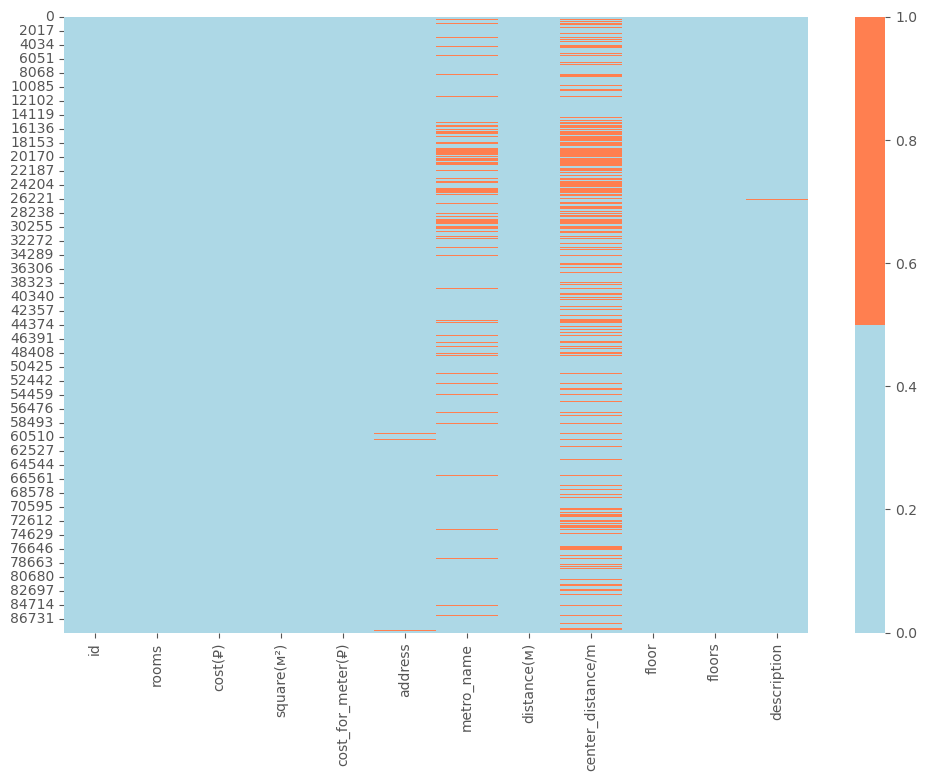

In [3]:
cols = df.columns[:30] # первые 30 колонок
# определяю цвета 
# салатовый - пропущенные данные, сиреневый - не пропущенные
colours = ["lightblue", 'coral'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [4]:
#Замена пропущенных категориальных признаков на _MISSING_ и числовых на 0
df['metro_name'] = df['metro_name'].fillna('_MISSING_')
df['description'] = df['description'].fillna('_MISSING_')
df['address'] = df['address'].fillna('_MISSING_')
df['center_distance/m']=df['center_distance/m'].fillna(0)

In [5]:
#Проверка
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
df.head(5)

id - 0%
rooms - 0%
cost(₽) - 0%
square(м²) - 0%
cost_for_meter(₽) - 0%
address - 0%
metro_name - 0%
distance(м) - 0%
center_distance/m - 0%
floor - 0%
floors - 0%
description - 0%


,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",_MISSING_,0.0,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


##### 2.2 Нахожу и удаляю выбросы

<AxesSubplot:>

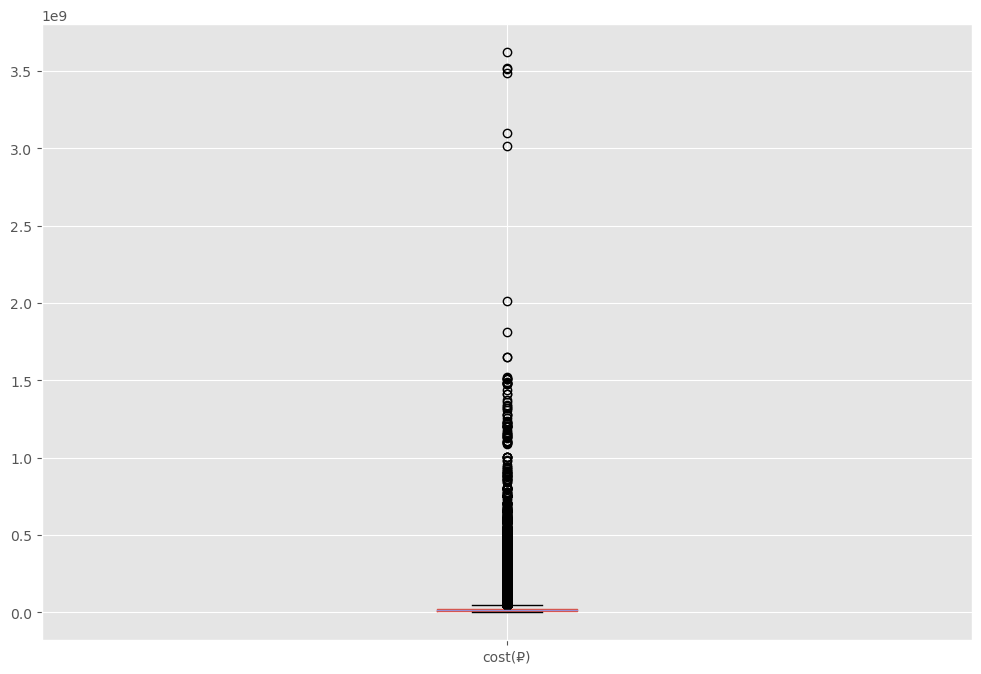

In [6]:
# Нахожу выбросы по цене
df.boxplot(column=['cost(₽)'])

In [7]:
# удаляю строки с выбросами
ind_missing = df[df['cost(₽)'] > 1600000000].index
df = df.drop(ind_missing, axis=0)

<AxesSubplot:>

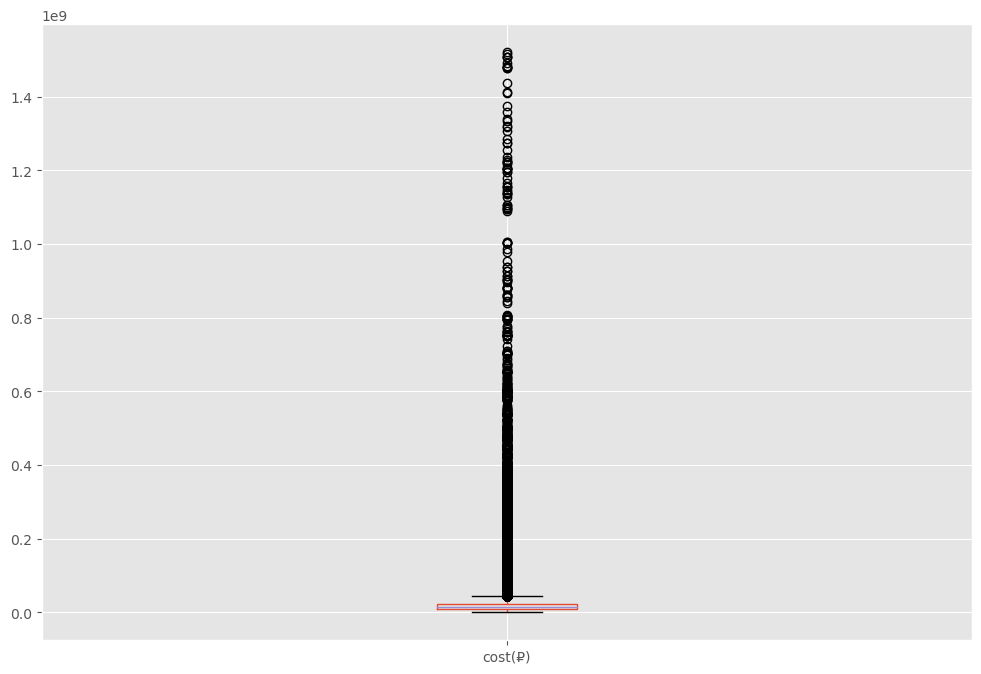

In [8]:
df.boxplot(column=['cost(₽)'])

In [9]:
# Заменю неизвестные строки столбца metro_name на _MISSING_
df.loc[df['center_distance/m'] == 0, 'metro_name'] = '_MISSING_' 
# Заменю неизвестные строки столбца distance(м) на 0
#df.loc[df['center_distance/m'] == 0, 'distance(м)'] = 0 

In [10]:
df.head(-1)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.30,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.40,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.10,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.30,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.50,"Центральная ул., 6",_MISSING_,0.0,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...
...,...,...,...,...,...,...,...,...,...,...,...,...
88709,88709,1-комн. квартира,6700000.0,30.6,218954.66,"Москва, 3-я Парковая улица, 7/17",измайловская,330.0,10700.0,2,5,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88710,88710,3-комн. квартира,8231888.0,58.4,140957.28,"Москва, Элеваторная улица, 14",_MISSING_,1200.0,0.0,3,12,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88711,88711,3-комн. квартира,16407663.5,74.8,219353.98,"Москва, Хорошёвское шоссе, 64к2",_MISSING_,663.0,0.0,5,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88712,88712,2-комн. квартира,9203120.0,53.9,170744.14,"Москва, Липецкая улица, 17к1",_MISSING_,1700.0,0.0,6,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...


In [11]:
# Заменю нули в двух столбцах значениями медианы
mean_distance = df["distance(м)"].median(skipna=True)
mean_center_distance = df["center_distance/m"].median(skipna=True)
print (mean_distance, mean_center_distance )

0    0.0
Name: distance(м), dtype: float64 0    0.0
Name: center_distance/m, dtype: float64


In [78]:
df["distance(м)"]=df['distance(м)'].mask(df['distance(м)'] == 0,mean_distance)
df["center_distance/m"]=df["center_distance/m"].mask(df["center_distance/m"] == 0,mean_center_distance)

In [79]:
df.head(-1)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.30,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.40,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.10,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.30,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.50,"Центральная ул., 6",_MISSING_,770.0,6600.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...
...,...,...,...,...,...,...,...,...,...,...,...,...
88709,88709,1-комн. квартира,6700000.0,30.6,218954.66,"Москва, 3-я Парковая улица, 7/17",измайловская,330.0,10700.0,2,5,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88710,88710,3-комн. квартира,8231888.0,58.4,140957.28,"Москва, Элеваторная улица, 14",_MISSING_,1200.0,6600.0,3,12,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88711,88711,3-комн. квартира,16407663.5,74.8,219353.98,"Москва, Хорошёвское шоссе, 64к2",_MISSING_,663.0,6600.0,5,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88712,88712,2-комн. квартира,9203120.0,53.9,170744.14,"Москва, Липецкая улица, 17к1",_MISSING_,1700.0,6600.0,6,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...


In [80]:
df.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Сlean.csv',index=True)
df.head(5)
df.shape

(88705, 12)

In [81]:
df = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Сlean.csv')
df= df.drop(columns='id') #удаляю колонку старого 'id'
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv',index=True)

df.head(-1)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.30,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.40,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.10,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.30,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.50,"Центральная ул., 6",_MISSING_,770.0,6600.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...
...,...,...,...,...,...,...,...,...,...,...,...,...
88699,88709,1-комн. квартира,6700000.0,30.6,218954.66,"Москва, 3-я Парковая улица, 7/17",измайловская,330.0,10700.0,2,5,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88700,88710,3-комн. квартира,8231888.0,58.4,140957.28,"Москва, Элеваторная улица, 14",_MISSING_,1200.0,6600.0,3,12,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88701,88711,3-комн. квартира,16407663.5,74.8,219353.98,"Москва, Хорошёвское шоссе, 64к2",_MISSING_,663.0,6600.0,5,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88702,88712,2-комн. квартира,9203120.0,53.9,170744.14,"Москва, Липецкая улица, 17к1",_MISSING_,1700.0,6600.0,6,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...


In [82]:
import pandas as pd 
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv',encoding='utf-8')
data = data.drop(['id'],axis=1) 
data.rename(columns = {'Unnamed: 0':"id"}, inplace = True) 
data.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv',index=False)
data.head(-1)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.30,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.40,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.10,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.30,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.50,"Центральная ул., 6",_MISSING_,770.0,6600.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...
...,...,...,...,...,...,...,...,...,...,...,...,...
88699,88699,1-комн. квартира,6700000.0,30.6,218954.66,"Москва, 3-я Парковая улица, 7/17",измайловская,330.0,10700.0,2,5,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88700,88700,3-комн. квартира,8231888.0,58.4,140957.28,"Москва, Элеваторная улица, 14",_MISSING_,1200.0,6600.0,3,12,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88701,88701,3-комн. квартира,16407663.5,74.8,219353.98,"Москва, Хорошёвское шоссе, 64к2",_MISSING_,663.0,6600.0,5,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88702,88702,2-комн. квартира,9203120.0,53.9,170744.14,"Москва, Липецкая улица, 17к1",_MISSING_,1700.0,6600.0,6,17,ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...


##### 2.3 Предобработка столбца с описанием (description)

In [35]:
import re  # Для препроцессинга
import pandas as pd
from time import time  # Для определения времени операций
import spacy
from spacy.lang.ru.examples import sentences 
from collections import defaultdict  # Для частоты слов
import logging  # Настройка для gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [36]:
# Считываю файл
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv')
df=data['description']

In [37]:
df.head(-5)

0        Прекрасная однокомнатная квартира в доме с лиф...
1        Светлая, просторная комната 19 кв. метров. Отд...
2        Первомайская, 15 мин. пешкомТёплая уютная квар...
3        в шаговой доступности парк Сокольники. , Разви...
4        Ильинское с.Все коммуникации центральные.Кварт...
                               ...                        
88695    Переуступка, входит в цену, 2 корпус, комнаты ...
88696    Продается трехкомнатная квартира, замечательно...
88697    ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
88698    Сначала читаем, потом звоним.)Согласно статье ...
88699    ПРОЧИТАЙТЕ ОБЪЯВЛЕНИЕ ПОЛНОСТЬЮ !!!Звонить СТР...
Name: description, Length: 88700, dtype: object

In [38]:
df.isnull().sum()

0

In [39]:
# Загружаю модель
!python -m spacy download ru_core_news_sm

     ---------------------------------------- 15.3/15.3 MB 8.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
nlp = spacy.load('ru_core_news_sm') # отключение распознавания именованных объектов для повышения скорости
def cleaning(doc):
    #Лемматизируется и удаляет стоп-слова
    # doc должен быть пространственным объектом Doc
    txt = [token.lemma_ for token in doc if not token.is_stop]
     # если предложение состоит всего из одного или двух слов,
    # польза от тренинга мала, поэтому
    if len(txt) > 2:
        return ' '.join(txt)
    #Удаляю неалфавитные символы:
brief_cleaning = (re.sub("[^А-Яа-я]", ' ', str(row)).lower() for row in data['description'])
    # Атрибут space .pipe() для ускорения процесса очистки:
# Подбираю оптимальное batch_size=2000, n_process=4
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2000, n_process=4)]
# Выведу общее время работы
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
#Помещаю результаты в фрейм данных
df_clean = pd.DataFrame({'clean': txt})
#Удаляю пробелы которых больше или равно 2 и сохраняю данные
df_clean['clean']= df_clean['clean'].str.replace(' {2,}', ' ', regex=True)
df_clean.head(-5)


INFO - 17:24:53: Loading dictionaries from c:\Users\Daniel\project university\venv\lib\site-packages\pymorphy3_dicts_ru\data
INFO - 17:24:53: format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962


Time to clean up everything: 18.93 mins


,clean
0,прекрасный однокомнатный квартира дом лифт мус...
1,светлый просторный комната кв метр отдельный л...
2,первомайский мин пешкомт плая уютный квартира ...
3,шаговый доступность парк сокольники развитой и...
4,ильинский коммуникация центральный квартира хо...
...,...
88695,переуступка входить цена корпус комната изолир...
88696,продаваться трехкомнатная квартира замечательн...
88697,прочитайте объявление полностью звонить строго...
88698,читать звоним согласно статья фз исполнительны...


In [73]:
df_clean.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\PRE.csv',index=False)


In [75]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88705 entries, 0 to 88704
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   clean   88490 non-null  object
dtypes: object(1)
memory usage: 693.1+ KB


##### 2.4 Векторизация описания (description) Doc2Vec

In [76]:
#использую реализацию Gensim Doc2Vec
import multiprocessing
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [77]:
# Загружаю данные
df_clean = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\PRE.csv')


In [78]:
cores = multiprocessing.cpu_count() # Количество ядер на компе
df_clean['clean']=df_clean['clean'].fillna("Без описания")# меняю нан на "Без описания"
#токенизация и добавление в текст
description = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_clean.clean)]

In [79]:
description[0]


TaggedDocument(words=['прекрасный', 'однокомнатный', 'квартира', 'дом', 'лифт', 'мусоропровод', 'балкон', 'больший', 'кухня', 'квартира', 'отделка', 'метро', 'бульвар', 'дмитрий', 'донцов', 'мин', 'транспорт'], tags=[0])

In [80]:
#Модель (#размер вектора, количество измерений, количество переборов, количество ядер)
d2v_model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=cores, epochs = 30, dm=0,dbow_words=1)
#Словарь
d2v_model.build_vocab(description)
#Обучение модели
d2v_model.train(description, total_examples=d2v_model.corpus_count
            , epochs=d2v_model.epochs)

INFO - 17:49:43: Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow+w,d64,n5,w2,s0.001,t16>', 'datetime': '2023-02-07T17:49:43.369454', 'gensim': '4.3.0', 'python': '3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
INFO - 17:49:43: collecting all words and their counts
INFO - 17:49:43: PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO - 17:49:43: PROGRESS: at example #10000, processed 633488 words (5872938 words/s), 14514 word types, 0 tags
INFO - 17:49:43: PROGRESS: at example #20000, processed 1208666 words (6278790 words/s), 20028 word types, 0 tags
INFO - 17:49:43: PROGRESS: at example #30000, processed 1763555 words (6136245 words/s), 23302 word types, 0 tags
INFO - 17:49:43: PROGRESS: at example #40000, processed 2777796 words (6722112 words/s), 26316 word types, 0 tags
INFO - 17:49:44: PROGRESS: at example #50000, processed 3910542 words (6503131 words/s), 30370 word type

In [81]:
#Генерация векторов
des2vec = [d2v_model.infer_vector((df_clean['clean'][i].split(' '))) for i in range(0,len(df_clean['clean']))]
#Проверяю тип данных
des2vec[0].dtype

dtype('float32')

In [82]:
#Переписываю векторы в датафрем
Vec64 = pd.DataFrame(data = des2vec)
Vec64.head(2)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.004816,0.057401,-0.023464,0.125655,-0.017740,-0.182973,0.811236,-0.336862,-0.677531,-0.380428,...,0.124530,0.152858,0.188257,0.009049,-0.193658,0.505134,-0.005088,0.007200,-0.472943,0.501702
1,0.021157,0.461886,-0.182979,0.055017,0.284309,-0.260959,0.475852,-0.143944,-0.733405,-0.244698,...,-0.011925,0.638489,0.095078,-0.286650,-0.041838,0.307241,-0.088520,-0.077666,0.008553,-0.081584


In [83]:
Vec64.shape
Vec64.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Vec64.csv',index=False)

In [84]:
#считываю csv для объединеня
df1 = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv')

In [85]:
#конкатенация
Data = pd.concat([df1, Vec64], axis=1)
Data=Data.drop(['description'], axis=1)#Удаляю столбец с описанием
Data.head(-1)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,...,54,55,56,57,58,59,60,61,62,63
0,0,1 – комнатная,5000000.0,31.0,161290.30,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,...,0.124530,0.152858,0.188257,0.009049,-0.193658,0.505134,-0.005088,0.007200,-0.472943,0.501702
1,1,1 комната,4500000.0,98.0,45918.40,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,...,-0.011925,0.638489,0.095078,-0.286650,-0.041838,0.307241,-0.088520,-0.077666,0.008553,-0.081584
2,2,1 – комнатная,10900000.0,36.1,301939.10,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,...,-0.311396,0.335607,-0.044676,0.260331,-1.008666,0.574376,0.203890,0.349756,-0.002050,-0.031896
3,3,1 комната,3650000.0,93.0,39247.30,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,...,-0.022867,0.590391,0.302100,-0.048893,-0.356030,0.448490,-0.414346,0.185249,0.317379,0.086985
4,4,доля (1/2),1200000.0,72.3,16597.50,"Центральная ул., 6",_MISSING_,770.0,6600.0,1,...,0.271917,0.339029,0.115451,0.042524,-0.429921,-0.099571,-0.319532,0.378762,-0.218053,0.008937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88699,88699,1-комн. квартира,6700000.0,30.6,218954.66,"Москва, 3-я Парковая улица, 7/17",измайловская,330.0,10700.0,2,...,0.118205,-0.714723,0.560473,-0.187859,-1.188088,-0.453324,-0.212949,0.359194,0.276468,0.544361
88700,88700,3-комн. квартира,8231888.0,58.4,140957.28,"Москва, Элеваторная улица, 14",_MISSING_,1200.0,6600.0,3,...,0.055292,-0.670313,0.607647,-0.104715,-1.186695,-0.505769,-0.239235,0.323199,0.301235,0.613457
88701,88701,3-комн. квартира,16407663.5,74.8,219353.98,"Москва, Хорошёвское шоссе, 64к2",_MISSING_,663.0,6600.0,5,...,0.155678,-0.700260,0.599260,-0.162537,-1.121336,-0.537613,-0.170771,0.335263,0.264857,0.554167
88702,88702,2-комн. квартира,9203120.0,53.9,170744.14,"Москва, Липецкая улица, 17к1",_MISSING_,1700.0,6600.0,6,...,0.083412,-0.652782,0.583734,-0.121629,-1.184659,-0.500666,-0.226300,0.346239,0.273423,0.510384


In [86]:
#Сохраняю данные
Data.to_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data1.csv',index=False)

##### 2.5 Енкодинг наименования метро

In [87]:
from sklearn.preprocessing import LabelEncoder

In [88]:
df = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data1.csv')

In [89]:
#Для преобразования использую LabelEncoder
labelencoder = LabelEncoder()
Mdf=df["metro_name"]
data_M = labelencoder.fit_transform(Mdf.values)
Metro_encoders = pd.DataFrame(data = data_M)
Metro_encoders.columns=['Metro_encoders']
Metro_encoders.head (5)

,Metro_encoders
0,30
1,71
2,60
3,171
4,0


In [90]:
Metro_encoders.max()

Metro_encoders    226
dtype: int32

In [91]:
#конкатенация
Data = pd.concat([df, Metro_encoders], axis=1)
Data.head(2)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,...,0.152858,0.188257,0.009049,-0.193658,0.505134,-0.005088,0.007200,-0.472943,0.501702,30
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,...,0.638489,0.095078,-0.286650,-0.041838,0.307241,-0.088520,-0.077666,0.008553,-0.081584,71


In [92]:
Data.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Data-teacher.csv',index=False)

In [93]:
Data=Data.drop(['metro_name',"rooms","address","id"],axis=1)#Удаляю столбец с предобработкой текста

In [94]:
Data.head(2)

,cost(₽),square(м²),cost_for_meter(₽),distance(м),center_distance/m,floor,floors,0,1,2,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,5000000.0,31.0,161290.3,4995.0,20600.0,2,4,-0.004816,0.057401,-0.023464,...,0.152858,0.188257,0.009049,-0.193658,0.505134,-0.005088,0.007200,-0.472943,0.501702,30
1,4500000.0,98.0,45918.4,420.0,11400.0,3,5,0.021157,0.461886,-0.182979,...,0.638489,0.095078,-0.286650,-0.041838,0.307241,-0.088520,-0.077666,0.008553,-0.081584,71


In [95]:
Data=Data.drop(["cost_for_meter(₽)",'floors'],axis=1)#Удаляю столбец с предобработкой текста
Data.head(2)

,cost(₽),square(м²),distance(м),center_distance/m,floor,0,1,2,3,4,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,5000000.0,31.0,4995.0,20600.0,2,-0.004816,0.057401,-0.023464,0.125655,-0.017740,...,0.152858,0.188257,0.009049,-0.193658,0.505134,-0.005088,0.007200,-0.472943,0.501702,30
1,4500000.0,98.0,420.0,11400.0,3,0.021157,0.461886,-0.182979,0.055017,0.284309,...,0.638489,0.095078,-0.286650,-0.041838,0.307241,-0.088520,-0.077666,0.008553,-0.081584,71


In [96]:
Data.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Data2.csv',index=False)

##### 2.6 Нормировка

In [26]:
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Data2.csv')

In [27]:
#Нормировка:
# загружаю библиотеку препроцесинга данных
# эта библиотека автоматически приведет данные к нормальным значениям
from sklearn import preprocessing
col = data.columns.values
scaler = preprocessing.MinMaxScaler()
data_scaled =scaler.fit_transform(data)
dataNorm = scaler.fit_transform(data)
dataNorm = pd.DataFrame(data = dataNorm,columns = data.columns.values)

In [4]:
#Стандартизация !!!!!!!  ЭТО БЫЛ ЭКСПЕРИМЕНТ

#from sklearn.preprocessing import StandardScaler
#col = data.columns.values
#scaler = StandardScaler()
#data_scaled =scaler.fit_transform(data)
#dataNorm = scaler.fit_transform(data)
#dataNorm = pd.DataFrame(data = dataNorm,columns = data.columns.values)

In [28]:
dataNorm.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Data.csv',index=False)

In [29]:
dataNorm

,cost(₽),square(м²),distance(м),center_distance/m,floor,0,1,2,3,4,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,0.003277,0.008187,0.004940,0.824490,0.021277,0.476659,0.490759,0.455079,0.420811,0.468252,...,0.503098,0.476971,0.514461,0.605165,0.642170,0.549615,0.466182,0.316721,0.565590,0.132743
1,0.002948,0.034308,0.000414,0.448980,0.031915,0.484837,0.631112,0.406401,0.401496,0.557048,...,0.648439,0.451144,0.417407,0.655100,0.578968,0.523475,0.440675,0.464249,0.404995,0.314159
2,0.007158,0.010175,0.001660,0.420408,0.010638,0.643970,0.503454,0.546985,0.340353,0.553066,...,0.557792,0.412408,0.596937,0.337097,0.664284,0.615088,0.569139,0.461000,0.418676,0.265487
3,0.002389,0.032359,0.001411,0.204082,0.042553,0.388116,0.694587,0.532403,0.464381,0.554926,...,0.634044,0.508526,0.495444,0.551758,0.624079,0.421393,0.519696,0.558872,0.451407,0.756637
4,0.000778,0.024288,0.000760,0.253061,0.010638,0.589936,0.521459,0.406193,0.414680,0.522696,...,0.558816,0.456791,0.525449,0.527454,0.449044,0.451099,0.577858,0.394818,0.429918,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88700,0.005403,0.018869,0.001185,0.253061,0.031915,0.552345,0.473822,0.298264,0.218170,0.528594,...,0.256737,0.593216,0.477122,0.278540,0.319315,0.476256,0.561158,0.553925,0.596360,0.000000
88701,0.010780,0.025263,0.000654,0.253061,0.053191,0.531165,0.491566,0.341514,0.189504,0.522332,...,0.247775,0.590892,0.458143,0.300038,0.309145,0.497706,0.564783,0.542779,0.580036,0.000000
88702,0.006042,0.017115,0.001680,0.253061,0.063830,0.560543,0.511506,0.327342,0.214172,0.501646,...,0.261984,0.586588,0.471570,0.279210,0.320945,0.480309,0.568082,0.545404,0.567981,0.000000
88703,0.004712,0.008070,0.000852,0.253061,0.031915,0.524941,0.486500,0.322078,0.213534,0.520650,...,0.259353,0.573687,0.461732,0.255803,0.333091,0.501317,0.570486,0.561322,0.577246,0.000000


## 3. Алгоритм knn

In [33]:
# модуль sparse библиотеки scipy понадобится 
# для работы с разреженными матрицами
from scipy.sparse import csr_matrix
# из sklearn импортирую алгоритм k-ближайших соседей
from sklearn.neighbors import NearestNeighbors

In [34]:
df = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Data.csv')

In [35]:
df.head()

,cost(₽),square(м²),distance(м),center_distance/m,floor,0,1,2,3,4,...,55,56,57,58,59,60,61,62,63,Metro_encoders
0,0.003277,0.008187,0.004940,0.824490,0.021277,0.476659,0.490759,0.455079,0.420811,0.468252,...,0.503098,0.476971,0.514461,0.605165,0.642170,0.549615,0.466182,0.316721,0.565590,0.132743
1,0.002948,0.034308,0.000414,0.448980,0.031915,0.484837,0.631112,0.406401,0.401496,0.557048,...,0.648439,0.451144,0.417407,0.655100,0.578968,0.523475,0.440675,0.464249,0.404995,0.314159
2,0.007158,0.010175,0.001660,0.420408,0.010638,0.643970,0.503454,0.546985,0.340353,0.553066,...,0.557792,0.412408,0.596937,0.337097,0.664284,0.615088,0.569139,0.461000,0.418676,0.265487
3,0.002389,0.032359,0.001411,0.204082,0.042553,0.388116,0.694587,0.532403,0.464381,0.554926,...,0.634044,0.508526,0.495444,0.551758,0.624079,0.421393,0.519696,0.558872,0.451407,0.756637
4,0.000778,0.024288,0.000760,0.253061,0.010638,0.589936,0.521459,0.406193,0.414680,0.522696,...,0.558816,0.456791,0.525449,0.527454,0.449044,0.451099,0.577858,0.394818,0.429918,0.000000


##### 3.1 Преобразование матрицы данных

In [36]:
# преобразую матрицу в формат csr
# метод values передаст функции csr_matrix только значения датафрейма
csr_data = csr_matrix(df.values)
print(csr_data[::])

  (0, 0)	0.0032769884875588
  (0, 1)	0.0081871345029239
  (0, 2)	0.0049403702358772
  (0, 3)	0.8244897959183674
  (0, 4)	0.0212765957446808
  (0, 5)	0.4766586377538482
  (0, 6)	0.4907592076495348
  (0, 7)	0.455079356312029
  (0, 8)	0.4208110683492777
  (0, 9)	0.4682522164426265
  (0, 10)	0.5229243136333459
  (0, 11)	0.735893356296342
  (0, 12)	0.4411160634392536
  (0, 13)	0.4377164637988243
  (0, 14)	0.4922263688795755
  (0, 15)	0.6123221563816124
  (0, 16)	0.5374095082027797
  (0, 17)	0.6470364614886318
  (0, 18)	0.5037634359018438
  (0, 19)	0.3533059313625627
  (0, 20)	0.4367437122012484
  (0, 21)	0.3583596097017974
  (0, 22)	0.3617545181463686
  (0, 23)	0.3850332736494234
  (0, 24)	0.5016687560887967
  :	:
  (88704, 45)	0.418119455553606
  (88704, 46)	0.3956045360452072
  (88704, 47)	0.4962683703510214
  (88704, 48)	0.7596559533665074
  (88704, 49)	0.2539914453410246
  (88704, 50)	0.4686297048529229
  (88704, 51)	0.3335617792962551
  (88704, 52)	0.6008214629246925
  (88704, 53)	0.62

In [38]:
csr_data

<88705x70 sparse matrix of type '<class 'numpy.float64'>'
	with 6180564 stored elements in Compressed Sparse Row format>

##### 3.2 Обучение модели

In [39]:
# создадю объект класса NearestNeighbors
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 10, n_jobs = -1)

# обучаю модель
#knn.fit(csr_data)
knn.fit(csr_data)
#metric = ‘cosine’: способ измерения расстояния - косинусное сходство
#algorithm = ‘brute’: буду искать решение методом полного перебора (brute force search), в данном случае пространство решений позволяет перебрать все варианты
#n_neighbors = 10: по скольким соседям ведется обучение
#n_jobs = -1: в этом случае предполагается, что вычисления будут вестись на всех свободных ядрах процессора

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [40]:
recommendations = 10
id = 3785
#с помощью метода .kneighbors() найдем индексы ближайших соседей.
distances, indices = knn.kneighbors(csr_data[id], n_neighbors = recommendations + 1)

#csr_data[id], то есть индекс запроса квартиры из матрицы в формате сжатого хранения строкой
#n_neighbors, количество соседей (или рекомендаций); добавляю «лишнего» соседа (+1) из-за того, что алгоритм также считает расстояние до самого себя

##### 3.3 Результат работы модели

In [41]:
# убираю лишние измерения через squeeze() и преобразуем массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()
 
# далее с помощью функций zip и list преобразую списки
indices_distances = list(zip(indices_list, distances_list))
 
# в набор кортежей (tuple)
print(type(indices_distances[0]))
 
# первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(3785, 2.220446049250313e-16), (47603, 0.016570247304152685), (72968, 0.018003386302239632)]


In [42]:
#  [(20243, 2.220446049250313e-16), (58157, 0.008500479119714521), (25618, 0.010574755066771635)]

# отсортировываю список по расстояниям через key = lambda x: x[1] (то есть по второму элементу)
# в возрастающем порядке reverse = False
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)
 
# и убраю первый элемент с индексом 56777 (потому что это и есть выбранная квартира)
indices_distances_sorted = indices_distances_sorted[1:]


In [43]:
indices_distances_sorted

[(47603, 0.016570247304152685),
 (72968, 0.018003386302239632),
 (30672, 0.018387657153224102),
 (30144, 0.020236086313103252),
 (14507, 0.020515758364495817),
 (13535, 0.020529225035436527),
 (84744, 0.021027786359008815),
 (51368, 0.021294767456916164),
 (88351, 0.021721440313438145),
 (393, 0.02217723297222296)]

##### 3.4 Получение рекомендаций

In [44]:
clean = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv')
clean.head(2)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."


In [46]:
# создаю пустой список, в который буду помещать парметры рекомендации и "расстояние" до нее
recom_list = []
 
# теперь в цикле буду поочередно проходить по кортежам
for ind_dist in indices_distances_sorted:
 
    # поиск id в clean.csv
    clean_id = clean.iloc[ind_dist[0]]['id']
    # индекс этого предложения
    id = clean[clean['id'] == clean_id].index
 
    # параметры и расстояние до рекомендации
    rooms = clean.iloc[id]["rooms"].values[0]
    cost = clean.iloc[id]["cost(₽)"].values[0]
    square = clean.iloc[id]["square(м²)"].values[0]
    cost_for_meter= clean.iloc[id]["cost_for_meter(₽)"].values[0]
    address= clean.iloc[id]["address"].values[0]
    metro_name= clean.iloc[id]["metro_name"].values[0]
    distance= clean.iloc[id]["distance(м)"].values[0]
    center_distance= clean.iloc[id]["center_distance/m"].values[0]
    floor= clean.iloc[id]["floor"].values[0]
    floors= clean.iloc[id]["floors"].values[0]
    description= clean.iloc[id]["description"].values[0]
    dist = ind_dist[1]
 
    # помещаю данные в словарь
    # который будет элементом списка recom_list
    recom_list.append({"rooms" : rooms,"cost(₽)": cost,"square(м²)":square,"cost_for_meter(₽)":cost_for_meter,
                        "address":address,"metro_name":metro_name,"distance(м)":distance,
                        "center_distance/m":center_distance,"floor":floor,"floors":floors,"description":description,'Distance': dist})

In [47]:
recom_list[0]

{'rooms': '2-комн. квартира',
 'cost(₽)': 11792000.0,
 'square(м²)': 64.5,
 'cost_for_meter(₽)': 182821.56,
 'address': 'Московская область, Ленинский городской округ, рабочий посёлок Дрожжино, Новое шоссе, 10к2',
 'metro_name': 'улица скобелевская',
 'distance(м)': 3700.0,
 'center_distance/m': 23300.0,
 'floor': 10,
 'floors': 20,
 'description': 'Продается просторная двухкомнатная квартира в новом доме, удачная распашная планировка с двумя санузлами, двумя лоджиями,просторной кухней.Чистый подъезд. консьерж. В шаговой доступности сетевые магазины, детский сад. школы, поликлиника, рядом Бутовский лесопарк с зоной отдыха. Удобная транспортная доступность, 15 минут до м. Бульвар Дмитрия Донского, МЦД Бутово 15 мин пешком, прямой выезд на Варшавское шоссе. Свободная продажа, полная стоимость, один собственник.',
 'Distance': 0.016570247304152685}

In [48]:
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description,Distance
1,2-комн. квартира,11792000.0,64.5,182821.56,"Московская область, Ленинский городской округ,...",улица скобелевская,3700.0,23300.0,10,20,Продается просторная двухкомнатная квартира в ...,0.016570
2,3-комн. квартира,11792000.0,67.6,174438.52,"Московская область, Ленинский городской округ,...",улица скобелевская,3100.0,23300.0,13,15,Id 19055. Продается 3-комнатная квартира. Обща...,0.018003
3,2 – комнатная,11600000.0,53.4,217228.50,"Изюмская ул., 49к4",улица скобелевская,924.0,23300.0,3,14,"Хорошее расположение дома, 10 минут ходьбы к с...",0.018388
4,1 – комнатная,9100000.0,35.6,255618.00,"Адмирала Лазарева ул., 42",улица горчакова,672.0,24200.0,4,12,"5 минут пешком от станции метро ""Ул. Горчакова...",0.020236
5,1 – комнатная,9300000.0,38.5,241558.40,"Венёвская ул., 15",улица скобелевская,672.0,23300.0,9,17,Просторная однокомнатная квартира. Один взросл...,0.020516
6,1 – комнатная,9100000.0,35.6,255618.00,"Адмирала Лазарева ул., 42",улица горчакова,840.0,24200.0,4,12,"5 минут пешком от станции метро ""Ул. Горчакова...",0.020529
7,2-комн. квартира,9648000.0,57.0,169263.44,"Московская область, Ленинский городской округ,...",улица скобелевская,3600.0,23300.0,7,17,Id 18526. Продается двухкомнатная квартира без...,0.021028
8,2-комн. квартира,13936000.0,54.4,256175.84,"Москва, 2-я Мелитопольская улица, 5к1",улица скобелевская,1600.0,23300.0,13,16,"1 собственник, МЦД БУТОВО В 4-5 МИНУТАХ ХОДЬБЫ...",0.021295
9,Квартира-студия,5252800.0,24.0,218866.22,"Москва, Чечёрский проезд, 38",улица горчакова,926.0,24200.0,1,9,"Продаётся квартира студия ,с евроремонтом От м...",0.021721
10,2 – комнатная,17200000.0,65.8,261398.20,"Поляны ул., 5Ак2",улица скобелевская,588.0,23300.0,17,17,"Бульвар Дмитрия Донского, 5 мин. транспортомВа...",0.022177


## 4. Сервис на Flask

In [52]:
!pip install flask

##### 4.1 Сохранение моделей

In [74]:
import pickle 
#Сохранение модели векторизации текста
nlppickle = open(r'C:\Users\Daniel\project university\Csv_to_html\PKL\nlppickle.pkl', 'wb')   
# Источник и назначение
pickle.dump(nlp, nlppickle)  
# закрыть файл
nlppickle.close()

In [116]:
import pickle 
#Сохранение модели векторизации текста
d2vpickle = open(r'C:\Users\Daniel\project university\Csv_to_html\PKL\d2vpickle.pkl', 'wb')   
# Источник и назначение
pickle.dump(d2v_model, d2vpickle)  
# закрыть файл
d2vpickle.close()

In [73]:
#сериализация модели нормировки
#from sklearn.preprocessing import MinMaxScaler
#import pickle 
#data = pd.read_csv(r'C:\Users\Daniel\project university\Выпускная работа\Data2.csv')
#scaler = preprocessing.MinMaxScaler()
#dataNorm = scaler.fit_transform(data)
#scalerPickle = open(r"C:\Users\Daniel\project university\Выпускная работа\Data\scaler.pkll", 'wb')
#pickle.dump(scaler, scalerPickle)

In [49]:
import pickle 
#Сохранение модели машинного обучения
knnPickle = open(r'C:\Users\Daniel\project university\Csv_to_html\PKL\knnpickle.pkl', 'wb')   
# Источник и назначение
pickle.dump(knn, knnPickle)  
# закрыть файл
knnPickle.close()

##### 4.2 Конвертация данных из csv в json

In [79]:
import pandas as pd  
df = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\Сlean.csv')

df.rename(columns = {'center_distance/m' : 'CenterDistance'}, inplace = True)
df.rename(columns = {'cost(₽)' : 'Cost'}, inplace = True)
df.rename(columns = {'square(м²)' : 'Square'}, inplace = True)
df.rename(columns = {'cost_for_meter(₽)' : 'CostForMeter'}, inplace = True)
df.rename(columns = {'distance(м)' : 'Distance'}, inplace = True)
df.rename(columns = {'address' : 'Addres'}, inplace = True)
df.rename(columns = {'metro_name' : 'MetroName'}, inplace = True)
df.rename(columns = {'floor' : 'Floor'}, inplace = True)
df.rename(columns = {'floors' : 'Floors'}, inplace = True)
df.rename(columns = {'description' : 'Description'}, inplace = True)
df.rename(columns = {'rooms' : 'Rooms'}, inplace = True)


df.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\Сlean.csv', index=False)

In [4]:
import pandas as pd 
#Выбираю столбцы для второго листа
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\metro.csv',encoding='utf-8')
data [["metro_name"]].to_csv(r'C:\Users\Daniel\project university\Csv_to_html\metro_name.csv',index=False, encoding='utf-8')

In [5]:
import csv 
import json 
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
    with open(csvFilePath, encoding='utf-8') as csvf: 
        csvReader = csv.DictReader(csvf) 
        for row in csvReader: 
            jsonArray.append(row)
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=0, ensure_ascii=False)
        jsonf.write(jsonString)
          
csvFilePath = r'C:\Users\Daniel\project university\Csv_to_html\metro_name.csv'
jsonFilePath = r'C:\Users\Daniel\project university\Csv_to_html\metro_name.json'
csv_to_json(csvFilePath, jsonFilePath)

In [58]:
import pandas as pd 
#Нахожу медиану для всех столбцов
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\Сlean.csv',encoding='utf-8')
data.head(5)

,id,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),center_distance/m,floor,floors,description
0,0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,20600.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,11400.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,10700.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,5400.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",_MISSING_,770.0,6600.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


In [59]:
import pandas as pd 
#Нахожу медиану для всех численных столбцов l
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\Сlean.csv',encoding='utf-8')
mean = data[["Cost","Square","Distance","Floor","Floors","CenterDistance"]].median()
print(mean)

KeyError: "None of [Index(['Cost', 'Square', 'Distance', 'Floor', 'Floors', 'CenterDistance'], dtype='object')] are in the [columns]"

In [60]:
#Доработка датасета, а именно перенумерация по id после удаления дубликатов

import pandas as pd 
data = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv',encoding='utf-8')
data = data.drop(['id'],axis=1) 
data.rename(columns = {'Unnamed: 0':"id"}, inplace = True) 
data.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\Сlean.csv',index=False)
data.head(-1)


KeyError: "['id'] not found in axis"

In [77]:
#Так же преобразую енкодером все станции метро в отдельном файле 
df = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\metro_name.csv')
labelencoder = LabelEncoder()
Mdf=df["metro_name"]
data_M = labelencoder.fit_transform(Mdf.values)
Metro_encoders = pd.DataFrame(data = data_M)
Metro_encoders.columns=['Metro_encoders']
Metro_encoders.head (5)
Data = pd.concat([df, Metro_encoders], axis=1)
Data.head(5)
Data.to_csv(r'C:\Users\Daniel\project university\Csv_to_html\Metro_encoders.csv', index=False)

In [11]:
#Визуализация
import pandas as pd
df_simple = pd.read_csv(r'C:\Users\Daniel\project university\Csv_to_html\ClassSave\DFProcessCost2.csv')
df_simple = df_simple.drop(columns='Metro_encoders') 
df_simple = df_simple.drop(columns='cost_for_meter(₽)') 
corr_matrix = df_simple.corr().round(2)
corr_matrix


,cost(₽),square(м²),distance(м),center_distance/m,floor,floors
cost(₽),1.00,0.76,-0.03,-0.23,0.07,0.03
square(м²),0.76,1.00,-0.03,-0.21,0.14,0.11
distance(м),-0.03,-0.03,1.00,0.10,0.00,-0.01
center_distance/m,-0.23,-0.21,0.10,1.00,0.03,0.03
floor,0.07,0.14,0.00,0.03,1.00,0.71
floors,0.03,0.11,-0.01,0.03,0.71,1.00


Text(0.5, 1.0, 'Влияние удаленности от центра на цену')

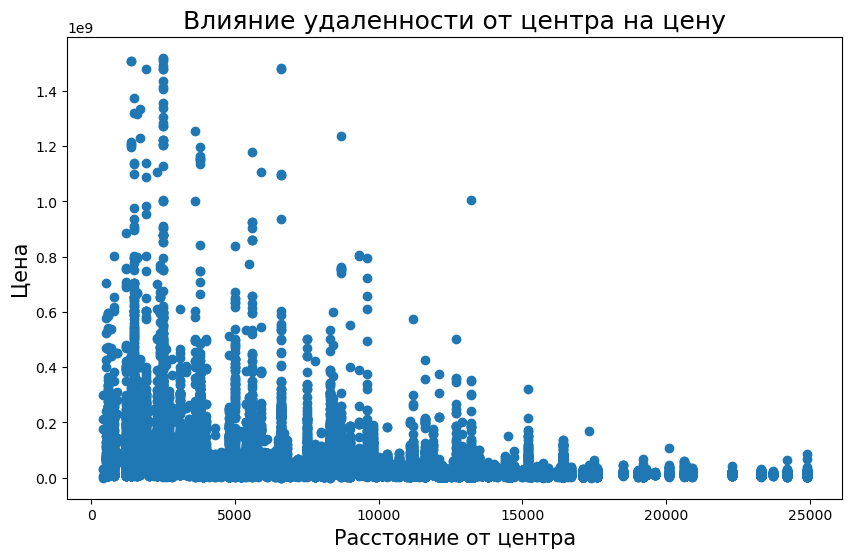

In [6]:
import matplotlib.pyplot as plt
x1 = df_simple['center_distance/m']
x2 = df_simple['square(м²)']
y = df_simple['cost(₽)']


# зададим размер и построим первый график
plt.figure(figsize = (10,6))
plt.scatter(x1, y)
 
# добавим подписи
plt.xlabel('Расстояние от центра', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Влияние удаленности от центра на цену', fontsize = 18)

Text(0.5, 1.0, 'Влияние площади на цену')

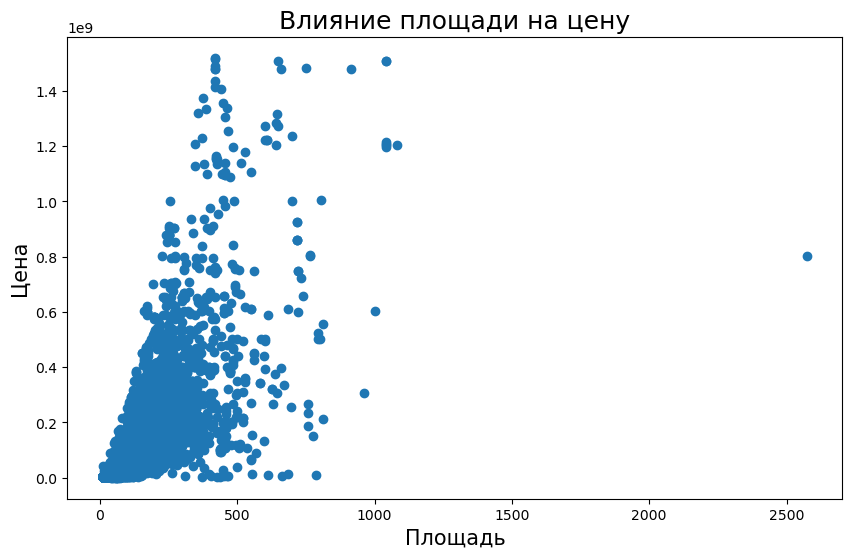

In [12]:
plt.figure(figsize = (10,6))
plt.scatter(x2, y)
 
# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Влияние площади на цену', fontsize = 18)

In [5]:
!pip install nbconvert


In [6]:
!jupyter nbconvert --to html Rec.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Rec.ipynb' matched no files
